# Two normal distribution
---

In [5]:
import torch, numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math, torch.nn as nn
from collections import deque

DEVICE        = 'cpu' 
T             = 500        # diffusion steps
BATCH_SIZE    = 512
TRAIN_ITERS   = 2000       # 訓練步數
LR            = 5e-4
HIDDEN        = 512
TIME_DIM      = 64
N_TRAIN_SAMP  = 10000       # 訓練資料量）
### Constants setting
betas = torch.linspace(1e-4, 0.02, T+1, device=DEVICE)
alphas = 1.0-betas
abar = torch.cumprod(alphas, dim=0)
sqrt_abar = torch.sqrt(abar)
sqrt_lmabar = torch.sqrt(1.0-abar)
sqrt_rcp_a = torch.sqrt(1.0 / alphas)


<class 'torch.Tensor'> torch.Size([10000, 1]) cpu


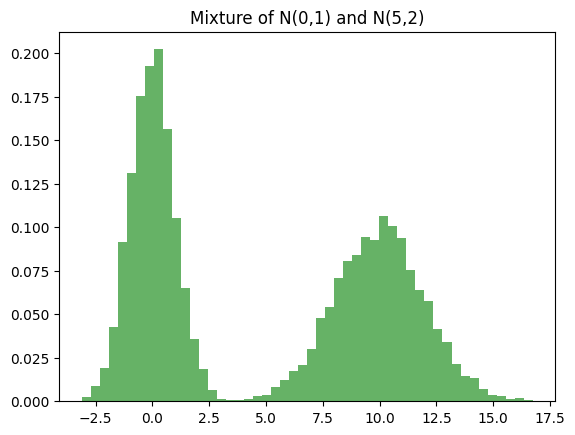

In [6]:
# 定義兩個 normal distribution
mu1, sigma1 = 0, 1   # N(0, 1)
mu2, sigma2 = 10, 2   # N(10, 2)

n_samples = 10000
weights = [0.5, 0.5]  # mixture ratio

# 先決定每個樣本從哪個分布來
choices = np.random.choice([0, 1], size=n_samples, p=weights)

# 依據 choices 產生樣本
samples = np.where(
    choices == 0,
    np.random.normal(mu1, sigma1, n_samples),
    np.random.normal(mu2, sigma2, n_samples)
)
# samples 是一維 numpy.ndarray，長度 n_samples
y0 = torch.tensor(samples, dtype=torch.float32, device=DEVICE).unsqueeze(1)  # 變成 (N,1)
print(type(y0), y0.shape, y0.device)  # 應該是 torch.Tensor, (10000, 1), cpu/cuda


# 畫圖
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g')
plt.title("Mixture of N(0,1) and N(5,2)")
plt.show()

In [10]:
### 這塊留給 time embedding
#-------------------------
def sinusoidal_time_emb(t, dim):
    # t: (B,) 的整數 timestep
    device = t.device
    t = t.float().unsqueeze(1)  # (B,1)
    half = dim // 2
    freqs = torch.exp(
        torch.arange(half, device=device).float() * (-math.log(10000.0) / max(1, half-1))
    )  # (half,)
    angles = t * freqs  # (B,half)
    emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=1)  # (B, 2*half)
    if dim % 2 == 1:  # 補一維避免奇數維崩
        emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)
    return emb  # (B, dim)

In [11]:
## 建nn
class EpsMLP(nn.Module):
    def __init__(self, hidden=HIDDEN, time_dim=TIME_DIM):
        super().__init__()
        self.time_dim = time_dim
        # 把 time embedding 投影到hidden layer
        self.t_proj = nn.Sequential(
            nn.Linear(time_dim, hidden), 
            nn.SiLU()
            )
        
        # y_t(1維) + time(hidden) → hidden → 1維噪聲預測
        in_dim = hidden + 1 # y+dim=1
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden,1)
        )
    def forward(self, y_t, t):
        t_emb = sinusoidal_time_emb(t, self.time_dim)   # (B, time_dim)
        h_t = self.t_proj(t_emb)                        # (B, hidden)
        h = torch.cat([y_t, h_t], dim=1)                # (B, 1+hidden)
        return self.net(h)

model = EpsMLP().to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=TRAIN_ITERS, eta_min=1e-5)  ###<---10/1新增
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,                      # 你的 optimizer
    mode='min',               # 要最小化的 metric（通常是 loss）
    factor=0.1,               # 沒改善時學習率乘上這個係數
    patience=20,              # 容忍多少次沒改善才觸發下降
    threshold=1e-3,           # 改善要超過多少幅度才算「有改善」
    threshold_mode='rel',     
    cooldown=5,               # 降完後等幾步再開始監控
    min_lr=1e-15,             # LR 不降到 0 以下
    verbose=True
)    ### <====10/22新增 下降lr用的scheduler

In [26]:
def q_sample(x0, t, eps=None):
    # x0: (B,1), t: (B,)
    if eps is None:
        eps = torch.randn_like(x0)
    sa  = sqrt_abar[t].view(-1, 1)       # (B,1)
    slm = sqrt_lmabar[t].view(-1, 1)     # (B,1)
    x_t = sa * x0 + slm * eps
    return x_t, eps

# ===== Validation setup (one-time) =====
VAL_SIZE = BATCH_SIZE  # 你也可改成 2*BATCH_SIZE 或 1024
g = torch.Generator(device=DEVICE).manual_seed(20251008)  # 固定種子

y0_val = torch.randn(VAL_SIZE, 1, generator=g, device=DEVICE)
t_val  = torch.randint(2, T+1, (VAL_SIZE,), generator=g, device=DEVICE)

@torch.no_grad()
def compute_val_loss():
    model.eval()
    y_t_val, eps_val = q_sample(y0_val, t_val)
    eps_hat_val = model(y_t_val, t_val)
    val_loss = F.mse_loss(eps_hat_val, eps_val)
    model.train()
    return float(val_loss.item())

def train_loop(y0: torch.Tensor, train_iters=2000, record_step=1):
    model.train()
    from collections import deque
    losses, movavg, ma = [], [], deque(maxlen=50)

    N = y0.shape[0]
    for step in range(train_iters):
        idx = torch.randint(0, N, (BATCH_SIZE,), device=DEVICE)
        x0  = y0[idx]                                        # ✅ 取出批次 (B,1)
        t   = torch.randint(1, T+1, (BATCH_SIZE,), device=DEVICE).long()

        x_t, eps   = q_sample(x0, t)                         # ✅ 傳 x0 不是 y0
        eps_hat    = model(x_t, t)
        loss       = F.mse_loss(eps_hat, eps)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        if step % record_step == 0:
            v = compute_val_loss()
            #v = float(loss.detach().item())
            losses.append(v); ma.append(v); movavg.append(sum(ma)/len(ma))
            ### <-------- 這裡餵validation loss 給scheduler0000
            scheduler.step(v)
            print(f"Step {step}: LR = {opt.param_groups[0]['lr']:.2e}")
#            lr_list.append(opt.param_groups[0]['lr'])

    return losses, movavg


In [21]:
def train_loop(y0, record_step=1, val_step=50, window=50, threshold=0.02):
    """
    y0: training data
    record_step: how often to record training loss
    val_step: how often to evaluate validation loss
    window: window size for moving average & fluctuation detection
    threshold: relative std threshold to reduce LR when oscillation detected
    """
    losses, val_losses, lr_list = [], [], []
    moving_avg = []
    last_mean = None

    for step in range(1, 2001):
        # forward + backward pass
        model.train()
        t = torch.randint(2, T+1, (BATCH_SIZE,), device=DEVICE).long()
        y_t, eps = q_sample(y0, t)
        eps_hat = model(y_t, t)
        loss = torch.mean((eps - eps_hat)**2)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

        # validation loss (every val_step)
        if step % val_step == 0:
            model.eval()
            with torch.no_grad():
                t_val = torch.randint(2, T+1, (BATCH_SIZE,), device=DEVICE).long()
                y_t_val, eps_val = q_sample(y0, t_val)
                eps_hat_val = model(y_t_val, t_val)
                val_loss = torch.mean((eps_val - eps_hat_val)**2).item()
                val_losses.append(val_loss)
            model.train()

            # === check for oscillation ===
            if len(val_losses) >= window:
                recent = val_losses[-window:]
                rel_std = np.std(recent) / np.mean(recent)
                if rel_std > threshold:
                    for g in opt.param_groups:
                        g['lr'] *= 0.1
                    print(f"[Step {step}] ⚠️ Loss oscillating! Reduce LR ×0.1")
            
            # record LR
            lr_list.append(opt.param_groups[0]['lr'])

        # optional moving average for smoother plotting
        if len(losses) >= window:
            moving_avg.append(np.mean(losses[-window:]))
        else:
            moving_avg.append(np.mean(losses))

        if step % 100 == 0:
            print(f"[train] step {step} | loss {loss.item():.6f} | val {val_losses[-1]:.6f} | LR={opt.param_groups[0]['lr']:.2e}")

    # === plot results ===
    steps = np.arange(len(losses))
    plt.figure(figsize=(8,5))
    plt.plot(steps, losses, label="loss (per step)")
    plt.plot(steps, moving_avg, label=f"moving avg ({window} steps)")
    plt.plot(np.arange(val_step, val_step*len(val_losses)+1, val_step), val_losses, label=f"validation ({val_step} steps)")
    plt.xlabel("training step")
    plt.ylabel("loss")
    plt.title("Training Loss & Moving Average & validation loss")
    plt.legend()
    plt.show()

    # === plot learning rate evolution ===
    plt.figure()
    plt.plot(np.arange(val_step, val_step*len(lr_list)+1, val_step), lr_list)
    plt.xlabel("validation step")
    plt.ylabel("lr")
    plt.title("Learning Rate Evolution")
    plt.show()

    return losses, val_losses, lr_list


In [27]:
losses, movavg=train_loop(y0, record_step=1)
steps = np.arange(len(losses))

Step 0: LR = 5.00e-04
Step 1: LR = 5.00e-04
Step 2: LR = 5.00e-04
Step 3: LR = 5.00e-04
Step 4: LR = 5.00e-04
Step 5: LR = 5.00e-04
Step 6: LR = 5.00e-04
Step 7: LR = 5.00e-04
Step 8: LR = 5.00e-04
Step 9: LR = 5.00e-04
Step 10: LR = 5.00e-04
Step 11: LR = 5.00e-04
Step 12: LR = 5.00e-04
Step 13: LR = 5.00e-04
Step 14: LR = 5.00e-04
Step 15: LR = 5.00e-04
Step 16: LR = 5.00e-04
Step 17: LR = 5.00e-04
Step 18: LR = 5.00e-04
Step 19: LR = 5.00e-04
Step 20: LR = 5.00e-04
Step 21: LR = 5.00e-04
Step 22: LR = 5.00e-04
Step 23: LR = 5.00e-04
Step 24: LR = 5.00e-04
Step 25: LR = 5.00e-04
Step 26: LR = 5.00e-04
Step 27: LR = 5.00e-04
Step 28: LR = 5.00e-04
Step 29: LR = 5.00e-04
Step 30: LR = 5.00e-04
Step 31: LR = 5.00e-04
Step 32: LR = 5.00e-04
Step 33: LR = 5.00e-04
Step 34: LR = 5.00e-04
Step 35: LR = 5.00e-04
Step 36: LR = 5.00e-05
Step 37: LR = 5.00e-05
Step 38: LR = 5.00e-05
Step 39: LR = 5.00e-05
Step 40: LR = 5.00e-05
Step 41: LR = 5.00e-05
Step 42: LR = 5.00e-05
Step 43: LR = 5.00e-0

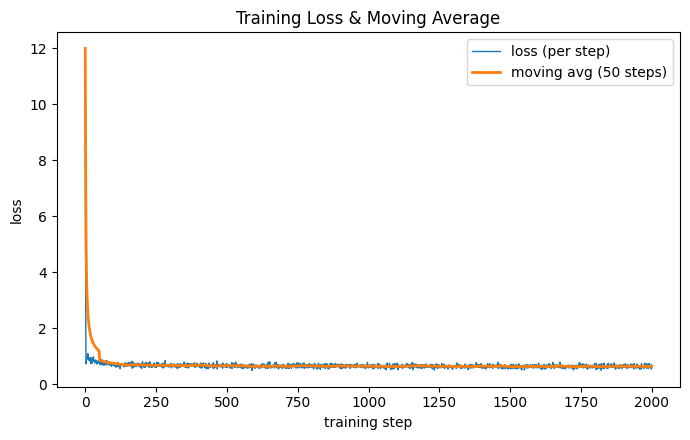

In [16]:
# 全部步數
plt.figure(figsize=(7,4.5))
plt.plot(steps, losses, label="loss (per step)", linewidth=1)
plt.plot(steps, movavg, label="moving avg (50 steps)", linewidth=2)
plt.xlabel("training step")
plt.ylabel("loss")
plt.title("Training Loss & Moving Average")
plt.legend()
plt.tight_layout()
plt.show()


=== Original (y0) vs Reconstructed (x0_hat) ===
mean: 5.0382 vs 5.0021
std : 5.2639 vs 4.7157
KS   : stat=0.0764, p=0.0000
t-test(means): stat=0.5110, p=0.6093
Levene(vars) : stat=727.2035, p=0.0000
Wasserstein-1: 0.6497


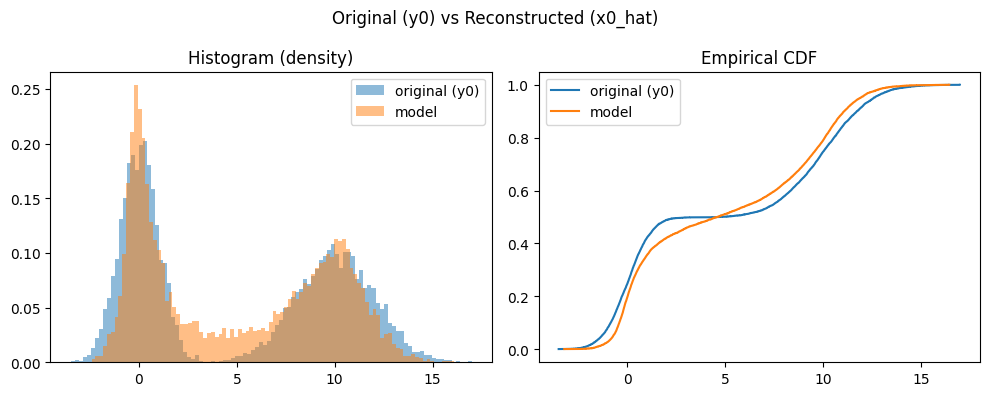

In [18]:
import numpy as np, torch, matplotlib.pyplot as plt
from scipy import stats

# ---------- 1) 重建 x0：用隨機 t 產生 x_t，再用模型預測 eps_hat 反推 ----------
@torch.no_grad()
def reconstruct_x0_with_model(y0: torch.Tensor, n=10000):
    model.eval()
    n = min(n, y0.shape[0])
    idx = torch.randint(0, y0.shape[0], (n,), device=y0.device)
    x0  = y0[idx]                                         # (n,1)
    t   = torch.randint(1, T+1, (n,), device=y0.device)   # (n,)
    eps = torch.randn_like(x0)
    x_t = sqrt_abar[t].unsqueeze(1)*x0 + sqrt_lmabar[t].unsqueeze(1)*eps
    eps_hat = model(x_t, t)
    # 由 x_t、t、eps_hat 估 x0：
    x0_hat = (x_t - sqrt_lmabar[t].unsqueeze(1)*eps_hat) / (sqrt_abar[t].unsqueeze(1)+1e-8)
    return x0_hat

# ---------- 2) 純生成：從 x_T ~ N(0, I) 反向到 0（DDPM 取樣） ----------
@torch.no_grad()
def sample_from_model(n=10000):
    model.eval()
    x_t = torch.randn(n, 1, device=DEVICE)
    for t in range(T, 0, -1):
        tt = torch.full((n,), t, device=DEVICE, dtype=torch.long)
        eps_hat = model(x_t, tt)
        a_t    = alphas[t]; abar_t = abar[t]; beta_t = betas[t]
        abar_tm1 = abar[t-1] if t > 1 else torch.tensor(1.0, device=DEVICE)
        beta_tilde = (1 - abar_tm1) / (1 - abar_t) * beta_t
        mean = (1.0/torch.sqrt(a_t))*(x_t - (beta_t/torch.sqrt(1-abar_t))*eps_hat)
        x_t = mean + (torch.sqrt(beta_tilde)*torch.randn_like(x_t) if t>1 else 0)
    return x_t  # ≈ x0_gen

# ---------- 3) 視覺化 + 統計檢定 ----------
def _to_np(x):
    if isinstance(x, torch.Tensor):
        return x.detach().flatten().cpu().numpy()
    return np.asarray(x).ravel()

def plot_and_tests(ref, cmp, title="compare"):
    A = _to_np(ref); B = _to_np(cmp)

    # 指標
    ks  = stats.ks_2samp(A, B)
    tt  = stats.ttest_ind(A, B, equal_var=False)
    lev = stats.levene(A, B)
    w1  = stats.wasserstein_distance(A, B)

    print(f"\n=== {title} ===")
    print(f"mean: {A.mean():.4f} vs {B.mean():.4f}")
    print(f"std : {A.std(ddof=1):.4f} vs {B.std(ddof=1):.4f}")
    print(f"KS   : stat={ks.statistic:.4f}, p={ks.pvalue:.4f}")
    print(f"t-test(means): stat={tt.statistic:.4f}, p={tt.pvalue:.4f}")
    print(f"Levene(vars) : stat={lev.statistic:.4f}, p={lev.pvalue:.4f}")
    print(f"Wasserstein-1: {w1:.4f}")

    # 圖：Histogram + ECDF
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].hist(A, bins=100, density=True, alpha=0.5, label="original (y0)")
    ax[0].hist(B, bins=100, density=True, alpha=0.5, label="model")
    ax[0].set_title("Histogram (density)"); ax[0].legend()

    xA = np.sort(A); FA = np.arange(1, len(A)+1)/len(A)
    xB = np.sort(B); FB = np.arange(1, len(B)+1)/len(B)
    ax[1].step(xA, FA, where="post", label="original (y0)")
    ax[1].step(xB, FB, where="post", label="model")
    ax[1].set_title("Empirical CDF"); ax[1].legend()

    fig.suptitle(title); fig.tight_layout(); plt.show()

# ---------- 4) 一鍵比較：原分布 vs 重建／生成 ----------
# 確保 y0 是 Tensor 形狀 (N,1)
if not isinstance(y0, torch.Tensor):
    y0 = torch.tensor(y0, dtype=torch.float32, device=DEVICE).unsqueeze(1)

x0_hat = reconstruct_x0_with_model(y0, n=10000)   # 重建
x0_gen = sample_from_model(n=10000)               # 純生成

plot_and_tests(y0, x0_hat, title="Original (y0) vs Reconstructed (x0_hat)")
#plot_and_tests(y0, x0_gen, title="Original (y0) vs Pure Generated (x0_gen)")
